In [1]:
import os

import odc.geo  # noqa
from odc.algo import mask_cleanup
from odc.stac import configure_rio, load
from pystac_client import Client

In [2]:
catalog = "https://cmr.earthdata.nasa.gov/cloudstac/LPCLOUD/"

# Searching across both landsat and sentinel at 30 m
collections = ["HLSS30.v2.0", "HLSL30.v2.0"]

client = Client.open(catalog)

In [3]:
# BBOX over Precipitous Bluff in Tasmania
ll = (-43.55, 146.45)
ur = (-43.35, 146.75)
bbox = [ll[1], ll[0], ur[1], ur[0]]

# Search for items in the collection
items = client.search(collections=collections, bbox=bbox, datetime="2023-07-01/2023-09-30").items()

In [4]:
items = [i for i in items]
print(f"Found {len(items)} items")

Found 102 items


In [5]:
# Configure GDAL. You need to export your earthdata token as an environment variable.
header_string = f"Authorization: Bearer {os.environ['EARTHDATA_TOKEN']}"
configure_rio(cloud_defaults=True, GDAL_HTTP_HEADERS=header_string)

data = load(
    items,
    bbox=bbox,
    crs="epsg:6933",
    resolution=30,
    chunks={"x": 2500, "y": 2500, "time": 1},
    groupby="solar_day",
    bands=["B04", "B03", "B02", "Fmask"]
)

# Get cloud  mask bitfields
# I think 1 is cloud, but I can't find docs...
# And bit 2 is a mess, but might be cloud shadow... not using that
# I can't actually find the cloud shadow bit
mask_bitfields = [1]  
bitmask = 0
for field in mask_bitfields:
    bitmask |= 1 << field

# Get cloud mask
cloud_mask = data["Fmask"].astype(int) & bitmask != 0

# Contract and then expand the cloud mask to remove small areas
dilated = mask_cleanup(cloud_mask, [("opening", 2), ("dilation", 3)])

masked = data.where(~dilated)
masked

<xarray.Dataset>
Dimensions:      (time: 46, y: 622, x: 966)
Coordinates:
  * y            (y) float64 -5.028e+06 -5.028e+06 ... -5.047e+06 -5.047e+06
  * x            (x) float64 1.413e+07 1.413e+07 ... 1.416e+07 1.416e+07
    spatial_ref  int32 6933
  * time         (time) datetime64[ns] 2023-07-01T00:18:58.755000 ... 2023-09...
Data variables:
    B04          (time, y, x) float32 dask.array<chunksize=(1, 622, 966), meta=np.ndarray>
    B03          (time, y, x) float32 dask.array<chunksize=(1, 622, 966), meta=np.ndarray>
    B02          (time, y, x) float32 dask.array<chunksize=(1, 622, 966), meta=np.ndarray>
    Fmask        (time, y, x) float32 dask.array<chunksize=(1, 622, 966), meta=np.ndarray>

/opt/homebrew/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


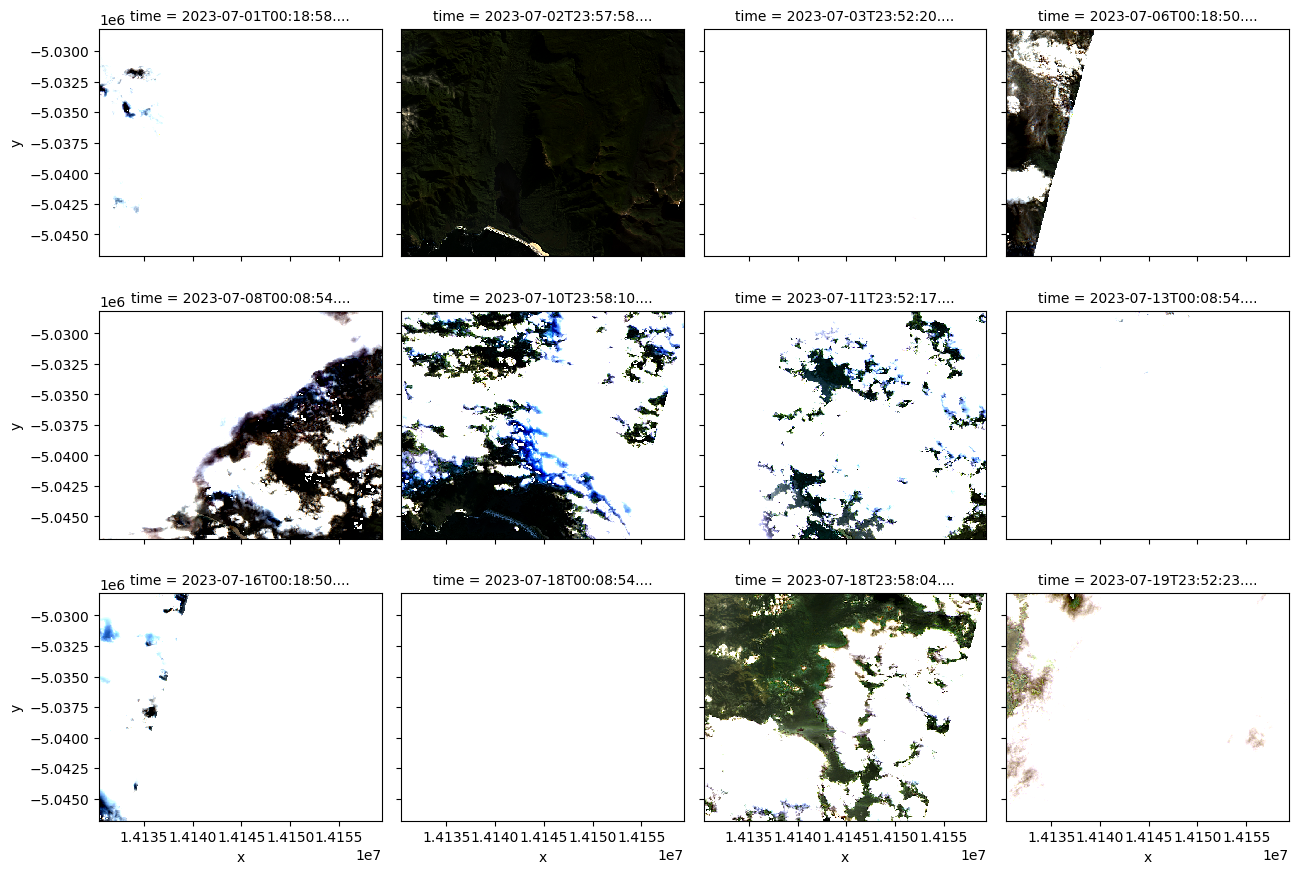

In [6]:
# Show the raw data
data[["B04", "B03", "B02"]].isel(time=slice(0, 12)).to_array().plot.imshow(
    col="time", col_wrap=4, vmin=0, vmax=3000
)

/opt/homebrew/lib/python3.11/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


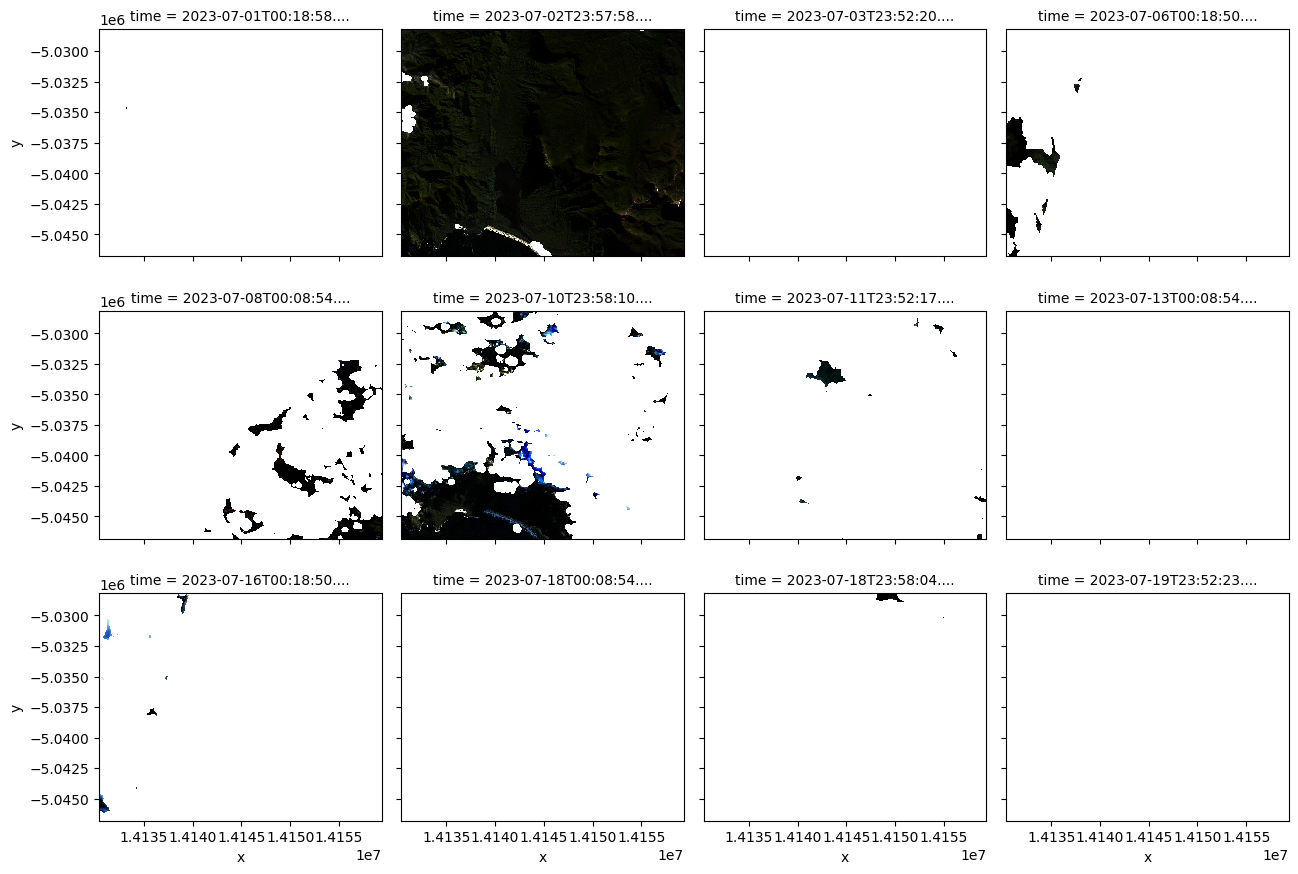

In [7]:
# Show it masked
masked[["B04", "B03", "B02"]].isel(time=slice(0, 12)).to_array().plot.imshow(
    col="time", col_wrap=4, vmin=0, vmax=3000
)

In [8]:
# Create a simple cloud-free median now we have masked data
median = masked.median("time").compute()

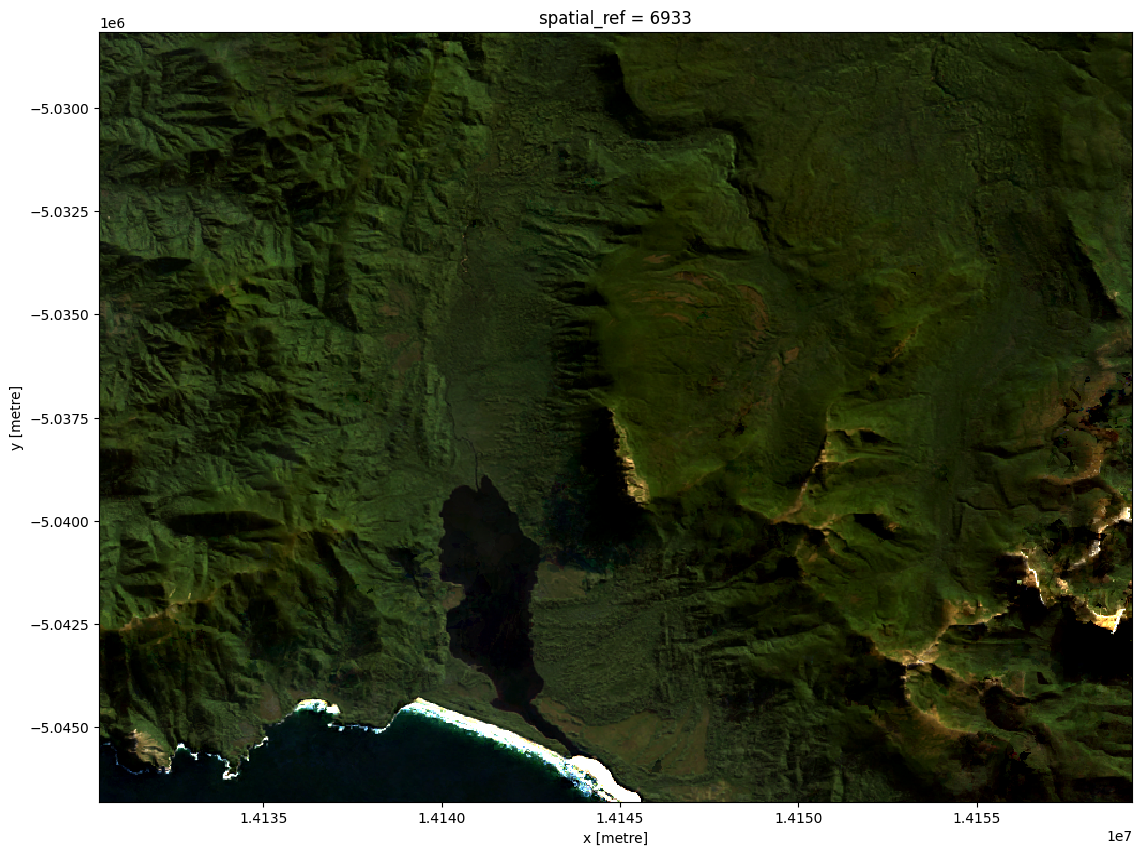

In [9]:
# Plot the median. This is just one month, so we expect
# some areas to be missing due to clouds
rgb = median[["B04", "B03", "B02"]].to_array()
rgb.plot.imshow(size=10, vmin=0, vmax=1000)